In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.metrics as sk

from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from scipy import stats

In [2]:
# Считываем данные для тренировки
data = pd.read_excel("training.xlsx", index_col=0)
data.head()

,Value
Date,
1959-01-01,22.8331
1959-02-01,23.2802
1959-03-01,23.6156
1959-04-01,24.1186
1959-05-01,24.4820


In [3]:
n = 5
mn = data['Value'].rolling(n).mean()  # Средняя скользящая статистика
data['Mean'] = mn  # Делаем новый столбец

st = data['Value'].rolling(n).std()  # Стандартное отклонение
data['Std'] = st  # Делаем новый столбец

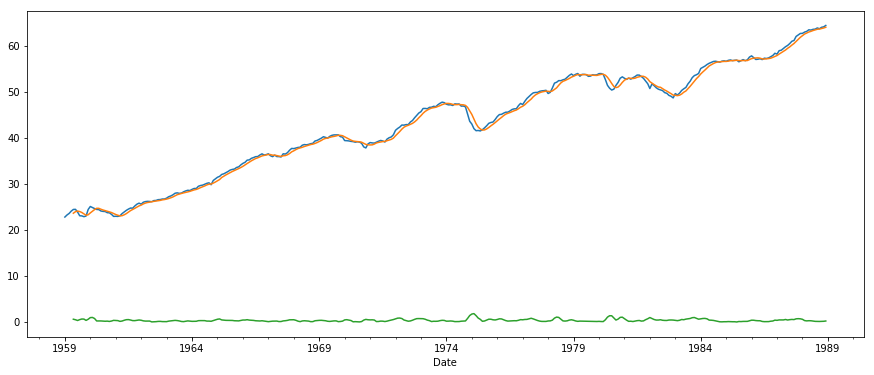

In [4]:
data.Value.plot(figsize=(15, 6))
data.Mean.plot(figsize=(15, 6))
data.Std.plot(figsize=(15, 6))

In [7]:
# Тест Дикки-Фуллера
X = data['Value'].values
test = sm.tsa.adfuller(X)
if test[0] > test[4]['5%']:
    print('Ряд не стационарен')
else:
    print('Ряд стационарен')

Ряд не стационарен


***Выводы:***
По графикам видно, что у ряда есть тренд, значит мат.ожидание увеличивается, т.е. ряд нестационарен.
Это подтверждает и тест Дикки-Фуллера

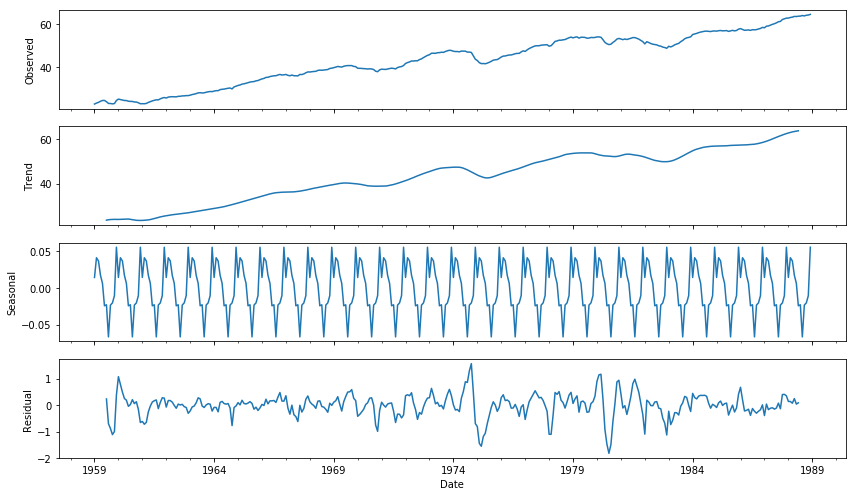

In [9]:
# Раскладываем на тренд и сезонность
rcParams['figure.figsize'] = 12, 7
# Аддитивная модель
res = sm.tsa.seasonal_decompose(data.Value, model='additive').plot()

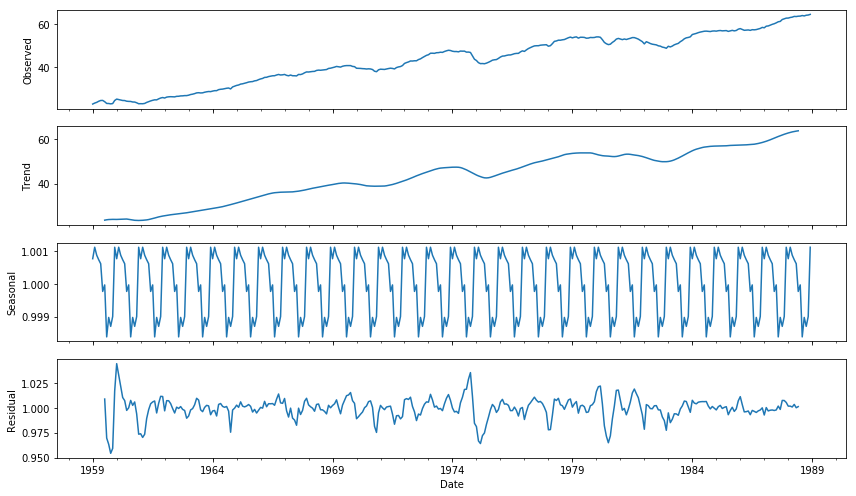

In [10]:
# Мультипликативная модель
res = sm.tsa.seasonal_decompose(data.Value, model='multiplicative').plot()

In [12]:
# Ищем индекс интегрируемости
def findk(dat, n):
    dat = dat.diff(periods=n).dropna()
    # diff - считает разность исходного ряда и ряда со смещением n
    # dropna - убирает первые NaN
    test = sm.tsa.adfuller(dat)  # Опять тест Дикки-Фуллера
    if test[0] > test[4]['5%']:
        return 0
    else:
        return n

k = 1


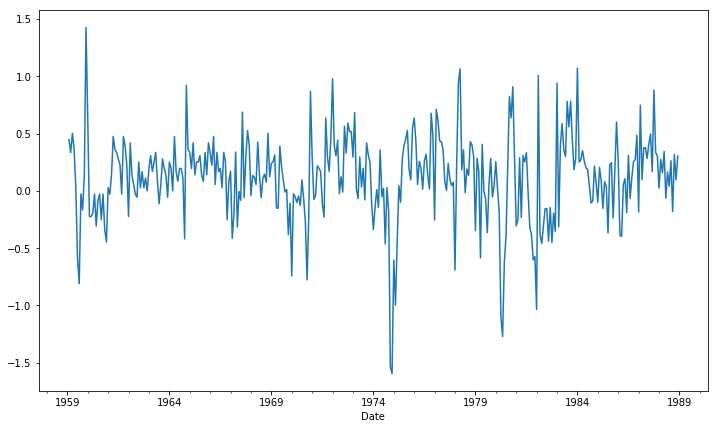

In [13]:
for i in range(1, data.Value.size):
    k = findk(data.Value, i)
    if k != 0:
        break
if k == data.Value.size:
    print('Ряд не является интегрируемым порядка k')
else:
    print('k =', k)
X1 = data.Value.diff(periods=k).dropna()
X1.plot()  # Тренд отсутствует, значит ряд стационарный

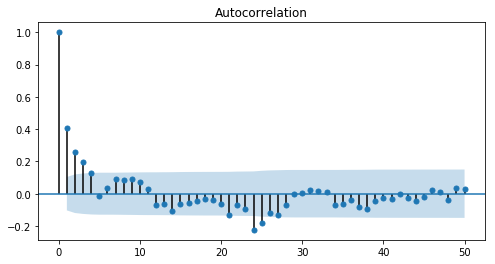

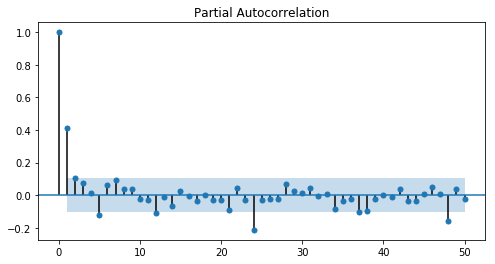

In [47]:
rcParams['figure.figsize'] = 8, 4
gr = sm.graphics.tsa.plot_acf(X1, lags=50)  # Автокорреляция
gr = sm.graphics.tsa.plot_pacf(X1, lags=50)  # Частичная автокорреляция
# ARIMA(p, d, q)
# d = k - порядок интегрируемости
# p - определяем по графику PACF
# q - определяем по графику ACF

In [142]:
%%time
# ARIMA p = 25, q = 3
model1 = sm.tsa.ARIMA(data.Value.squeeze(), order=(25, 1, 3),).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Wall time: 17min 46s


In [143]:
%%time
# ARIMA p = 1, q = 3
model2 = sm.tsa.ARIMA(data.Value.squeeze(), order=(1, 1, 3),).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Wall time: 361 ms


In [144]:
%%time
# ARIMA p = 12, q = 3
model3 = sm.tsa.ARIMA(data.Value.squeeze(), order=(12, 1, 3),).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Wall time: 37.3 s


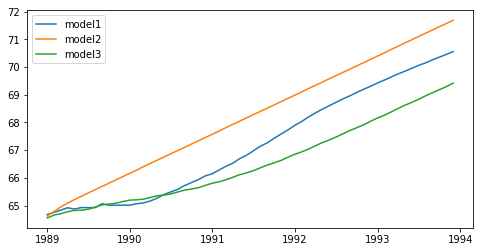

In [145]:
# Предсказываем значения для следующих дат
pred1 = model1.predict(start='1989-01-01', end='1993-12-01', typ='levels')
pred2 = model2.predict(start='1989-01-01', end='1993-12-01', typ='levels')
pred3 = model3.predict(start='1989-01-01', end='1993-12-01', typ='levels')
# График, чтобы посмотреть насколько предсказания отличаются
plt.plot(pred1, label='model1')
plt.plot(pred2, label='model2')
plt.plot(pred3, label='model3')
plt.legend(loc='best')

In [146]:
# Считываем данные для теста
datat = pd.read_excel("testing.xlsx", index_col=0)
datat.tail()

,Value
Date,
1993-08-01,67.5985
1993-09-01,67.9241
1993-10-01,68.4390
1993-11-01,68.7289
1993-12-01,69.0884


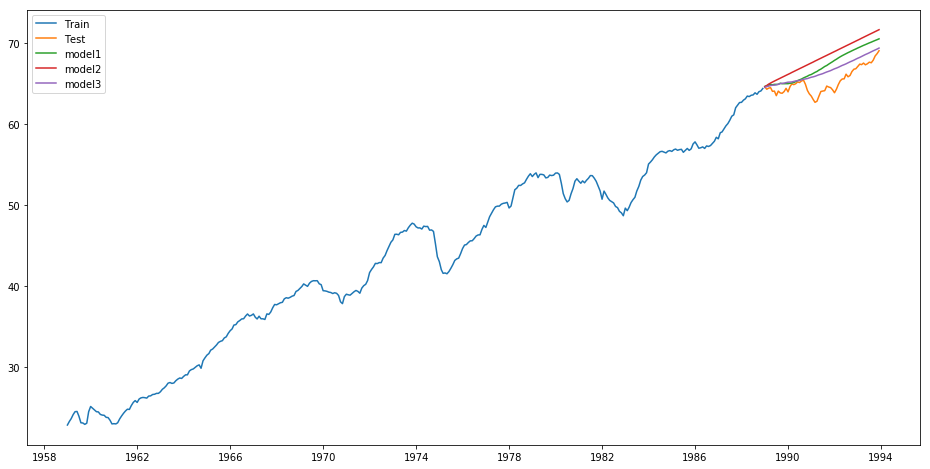

In [147]:
# График, чтобы посмотреть насколько точно предсказали значения
plt.figure(figsize=(16, 8))
plt.plot(data.Value, label='Train')
plt.plot(datat.Value, label='Test')
plt.plot(pred1, label='model1')
plt.plot(pred2, label='model2')
plt.plot(pred3, label='model3')
plt.legend(loc='best')
plt.show()

In [149]:
# R2 score: чем больше, тем лучше
r21 = sk.r2_score(datat.Value, pred1)
r22 = sk.r2_score(datat.Value, pred2)
r23 = sk.r2_score(datat.Value, pred3)
print('r2 model1:', r21)
print('r2 model2:', r22)
print('r2 model3:', r23)

r2 model1: -1.081638861679084
r2 model2: -3.32067665533034
r2 model3: 0.020449685874000978


In [150]:
# Критериq Акаике: чем меньше, тем лучше
ak1 = model1.aiс
ak2 = model2.aic
ak3 = model3.aic
print('AIC model1:', ak1)
print('AIC model2:', ak2)
print('AIC model3:', ak3)


AIC model1: 261.60161023616865
AIC model2: 251.08321143936394
AIC model3: 248.79218215212347


***Выводы:***
Наилучшая модель по критерию Акаике - модель с аргументами p = 12, q = 3.
Модель с маленькими значениями аргументов плохо предсказывает значения.
Модель с большими значениями аргументов предсказывает начальные значения лучше всех, но дальше хуже, чем третья модель, кроме того она неэффективна по времени и из-за большого количества аргументов имеет самое большое число по критерию Акаике.